In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn.svm import SVC
from sklearn.metrics import classification_report
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import SnowballStemmer
from bs4 import BeautifulSoup
import string
from gensim.models.fasttext import FastText
import torch
import torchtext.vocab as vocab

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_set = pd.read_csv('training_set.txt', sep='\t')
dev_set = pd.read_csv('dev_set.txt', sep='\t')

    • 1: Anger
    • 2: Anticipation
    • 3: Disgust
    • 4: Fear
    • 5: Joy
    • 6: Sadness
    • 7: Surprise
    • 8: Trust

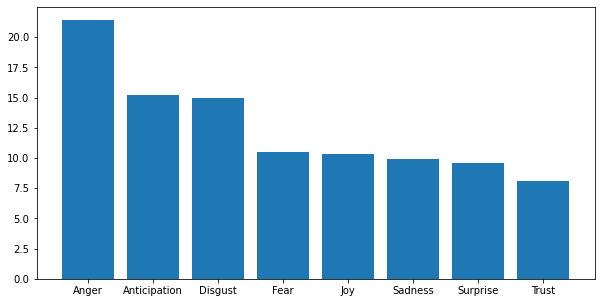

In [9]:
targerts_values=train_set.emotion.value_counts(normalize=True)*100
fig, ax = plt.subplots(figsize=(10,5))
targerts_values.set_axis(['Anger','Anticipation','Disgust','Fear','Joy','Sadness','Surprise','Trust'] , inplace=True)
plt.bar(x=targerts_values.index,height=targerts_values.values)
plt.show()

In [63]:

stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
snowball_stemmer = SnowballStemmer('english')

In [46]:
puntuation = pd.DataFrame(np.zeros((len(train_set),len(stop))),columns=stop)
puntuation['emotion'] = train_set['emotion']

for i in range(len(train_set)):
    sentence_split = train_set.sentence[i].split()
    for j in sentence_split:
        if j in stop:
            puntuation[j][i] = 1
            
for i in puntuation.columns:
    if sum(puntuation[i]) < 100:
        puntuation.drop(columns = i,inplace= True)
        
final_table = puntuation.groupby('emotion').sum().set_axis(['Anger','Anticipation','Disgust','Fear','Joy','Sadness','Surprise','Trust'])

for i in targerts_values.index:
    final_table.loc[i] /= (targerts_values[i]*140)

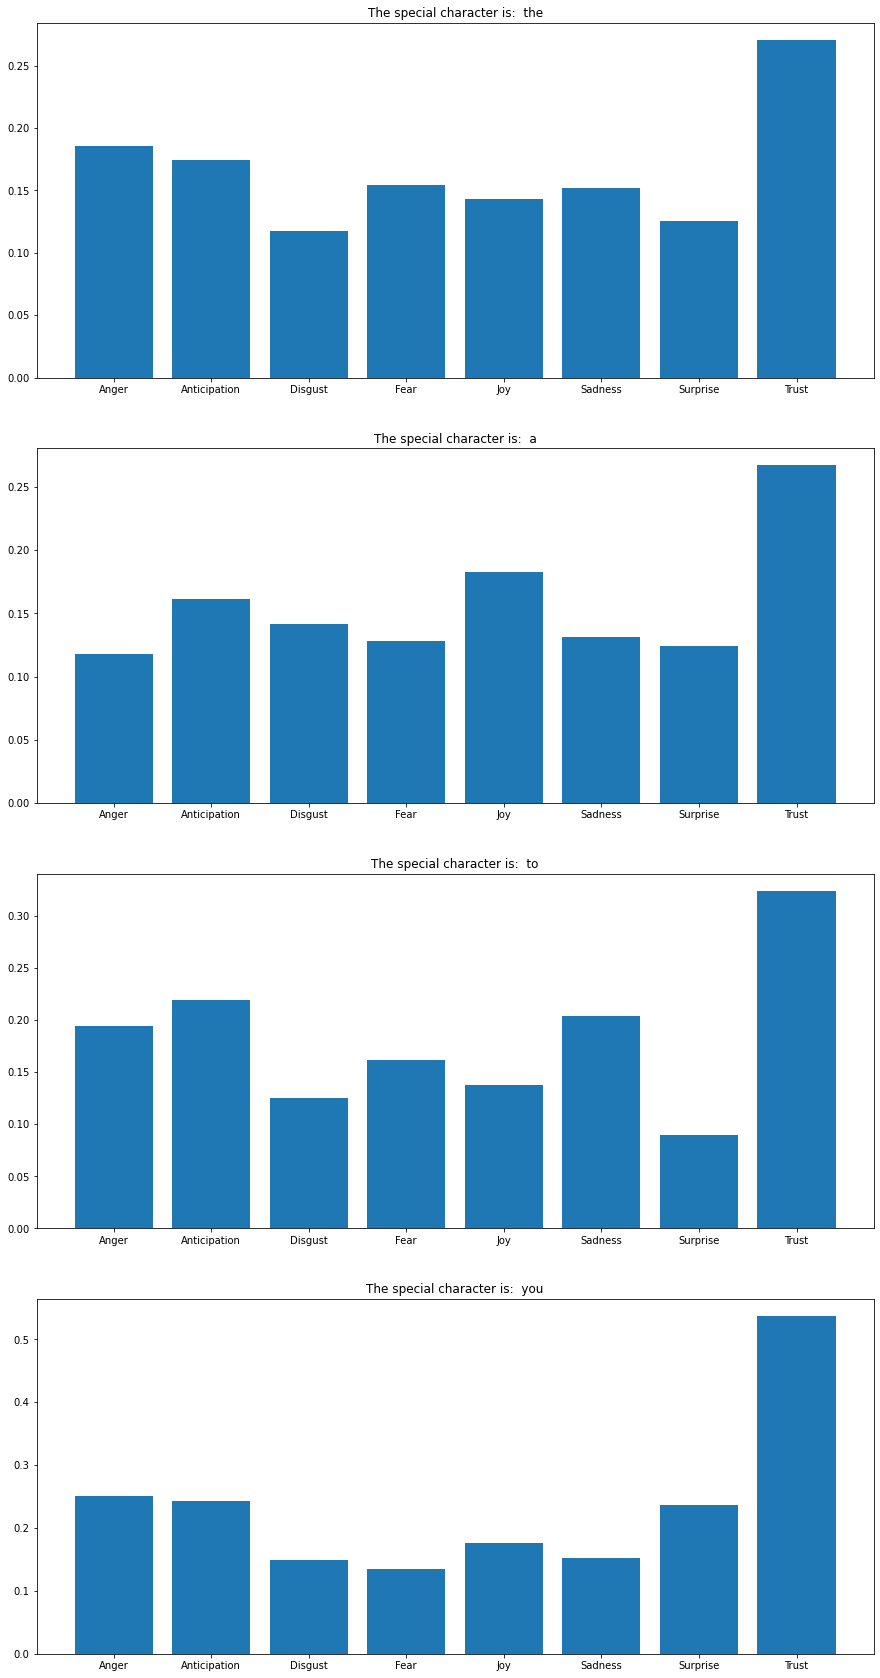

In [52]:
index= np.unique(np.where(final_table >0.2)[1])


fig, ax = plt.subplots(len(np.unique(np.where(final_table >0.2)[1])),1,figsize=(15,30))

for axis, col in zip(ax.flatten(),final_table.iloc[:,index].columns):
    axis.bar(x=final_table.index,height=final_table[col].values)
    axis.set_title('The special character is:  '+col)
plt.show()

In [3]:
def clean(text_list, lemmatize, stemmer):
    """
    Function that a receives a list of strings and preprocesses it.
    
    :param text_list: List of strings.
    :param lemmatize: Tag to apply lemmatization if True.
    :param stemmer: Tag to apply the stemmer if True.
    """
    
    updates = []
    for j in tqdm(range(len(text_list))):
        
        text = text_list[j]
        text = text.lower()
        #REMOVE THAT IS NOT TEXT
        text = re.sub("[0-9]", ' ', text)
        text = re.sub("'", ' ', text, flags=re.I)
        text = re.sub('(\[|\])',' ',text)
        
        text = re.sub(':','',text) 
        text = re.sub('--','',text) 
        text = re.sub('soltáis','',text)
        text = re.sub('empathicalist','',text)
        text = re.sub('\*','',text)
        text = re.sub('-',' - ',text)
        text = re.sub('nuggies','',text)
        text = re.sub('sourcastic','',text)
        text = re.sub('buljanoff','person',text)
        text = re.sub('verua','',text)
        text = re.sub('amalgate','combine',text)
        text = re.sub('approvechamos','',text) 
        text = re.sub('dogl','dog',text) 
        text = re.sub('helaros','ice cream',text)
        text = re.sub('ruuuuuth !','ruth !!!!!',text)
        text = re.sub('radarjockeys','',text)
        text = re.sub('favrinis','favrini',text)
        text = re.sub('tadminster','',text)
        text = re.sub('buckoes','bucko',text)
        text = re.sub('päätti','',text)
        text = re.sub('teidät','',text)
        text = re.sub('tilalle','',text)
        text = re.sub('volavent','pie',text)
        text = re.sub('päiväsi on lopussa','your day is over',text)
        text = re.sub('obsolescing','obsolesce',text)
        text = re.sub('adiran','',text)
        text = re.sub('shikseh','food',text)
        text = re.sub('hundjager','animal',text)
        text = re.sub('devriess','person',text)
        text = re.sub('shalakazam','magic',text)
        text = re.sub('=','equal',text)
        text = re.sub('dovitch ','person',text)
        text = re.sub('chewgood ','',text)
        text = re.sub('kamoja ','',text)
        text = re.sub('hourses ','horses',text)
        text = re.sub('disppearance','disappearance',text)
        text = re.sub('monosyllabically','',text)
        text = re.sub('alonger','',text)
        text = re.sub('oextry','',text)
        text = re.sub('azupep', '',text)
        text = re.sub('suitcoat', '',text)
        text = re.sub('scuzzball', 'disgusting person',text)
        text = re.sub('bited', 'bit',text)
        text = re.sub('antinuke', 'anti nuke',text)
        text = re.sub('jouncing', 'jounce',text)
        text = re.sub('neverjoke', 'never joke',text)
        text = re.sub('couid', 'could',text)
        
        aux = []
        for i in text.split():
            i = re.sub(r'[\w\s]+[?.!:]+$', i.translate(str.maketrans('', '', string.punctuation)), i)
            aux.append(re.sub(r'[.!?:]+', ' '.join(i), i))

        text = ' '.join(aux)

        
        #REMOVE STOP WORDS
        #text = " ".join([word for word in text.split() if word not in stop ])
        
        #text = " ".join([word for word in text.split() if word not in exclude ])
        
        #LEMMATIZATION
        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())
        
        #STEMMER
        if stemmer:
            text = " ".join(snowball_stemmer.stem(word) for word in text.split())
            
        text = re.sub('breechclouted','breechclout',text) 
        text = re.sub('coldcocked','coldcock',text) 
        text = re.sub('upchucked','upchuck',text) 
        
        
        updates.append(text)
        
    return updates

In [500]:
train_set.iloc[11268 ]['sentence']

'Since when is the disppearance of a human being considered trash , in your estimation , Ms Bantam ?'

In [4]:

train_set['sentence'] = clean(train_set['sentence'], lemmatize = True, stemmer = False)
dev_set['sentence'] = clean(dev_set['sentence'], lemmatize = False, stemmer = False)

  0%|          | 0/14000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

# Baseline

In [218]:
cv = CountVectorizer(max_df=0.9)
X = cv.fit_transform(train_set['sentence'])
y = np.array(train_set["emotion"])
Test = cv.transform(dev_set['sentence'])
y_hat = np.array(dev_set["emotion"])
model = SVC(C=0.85,kernel='linear')
model.fit(X,y)
predict = model.predict(Test)
labels = {"Anger": 1, "Anticipation": 2, "Disgust": 3, "Fear": 4, "Joy": 5, "Sadness": 6, "Surprise": 7, "Trust": 8}
print (classification_report(predict, y_hat, target_names=labels.keys()))

              precision    recall  f1-score   support

       Anger       0.58      0.32      0.41       381
Anticipation       0.35      0.36      0.36       168
     Disgust       0.17      0.28      0.21        46
        Fear       0.25      0.33      0.28        79
         Joy       0.38      0.42      0.40        89
     Sadness       0.24      0.35      0.29        60
    Surprise       0.17      0.29      0.21        55
       Trust       0.29      0.38      0.33       122

    accuracy                           0.34      1000
   macro avg       0.30      0.34      0.31      1000
weighted avg       0.40      0.34      0.35      1000



In [219]:
print (classification_report(model.predict(X), y, target_names=labels.keys()))

              precision    recall  f1-score   support

       Anger       0.82      0.56      0.67      4407
Anticipation       0.68      0.65      0.66      2211
     Disgust       0.61      0.86      0.71       952
        Fear       0.55      0.74      0.63      1076
         Joy       0.72      0.74      0.73      1430
     Sadness       0.59      0.74      0.66      1109
    Surprise       0.50      0.74      0.59       770
       Trust       0.62      0.63      0.62      2045

    accuracy                           0.66     14000
   macro avg       0.64      0.71      0.66     14000
weighted avg       0.69      0.66      0.66     14000



# Don't removing Stop words

In [420]:
tfid = TfidfVectorizer(max_features=14000,ngram_range=(1,2))
X = tfid.fit_transform(train_set['sentence'])
y = np.array(train_set["emotion"])
Test = tfid.transform(dev_set['sentence'])
y_hat = np.array(dev_set["emotion"])
model = SVC(C=0.85,kernel='linear')
model.fit(X,y)
predict = model.predict(Test)
labels = {"Anger": 1, "Anticipation": 2, "Disgust": 3, "Fear": 4, "Joy": 5, "Sadness": 6, "Surprise": 7, "Trust": 8}
print (classification_report(predict, y_hat, target_names=labels.keys()))

              precision    recall  f1-score   support

       Anger       0.61      0.35      0.44       369
Anticipation       0.51      0.44      0.48       196
     Disgust       0.09      0.22      0.13        32
        Fear       0.24      0.37      0.29        68
         Joy       0.38      0.45      0.41        82
     Sadness       0.29      0.37      0.32        67
    Surprise       0.18      0.39      0.24        44
       Trust       0.36      0.40      0.38       142

    accuracy                           0.38      1000
   macro avg       0.33      0.37      0.34      1000
weighted avg       0.45      0.38      0.40      1000



In [211]:
print (classification_report(model.predict(X), y, target_names=labels.keys()))

              precision    recall  f1-score   support

       Anger       0.90      0.59      0.71      4533
Anticipation       0.78      0.69      0.73      2382
     Disgust       0.51      0.85      0.64       795
        Fear       0.58      0.81      0.68      1047
         Joy       0.71      0.82      0.76      1287
     Sadness       0.64      0.80      0.71      1107
    Surprise       0.54      0.79      0.64       771
       Trust       0.71      0.71      0.71      2078

    accuracy                           0.71     14000
   macro avg       0.67      0.76      0.70     14000
weighted avg       0.75      0.71      0.71     14000



# Using FastText

In [ ]:
def clean(text_list, lemmatize, stemmer):
    """
    Function that a receives a list of strings and preprocesses it.
    
    :param text_list: List of strings.
    :param lemmatize: Tag to apply lemmatization if True.
    :param stemmer: Tag to apply the stemmer if True.
    """
    
    updates = []
    for j in tqdm(range(len(text_list))):
        
        text = text_list[j]
        text = text.lower()
        #REMOVE THAT IS NOT TEXT
        text = re.sub("[0-9]", ' ', text)
        text = re.sub("'", ' ', text, flags=re.I)
        text = re.sub('(\[|\])',' ',text)
        
        text = re.sub(':','',text) 
        text = re.sub('--','',text) 
        text = re.sub('soltáis','',text)
        text = re.sub('empathicalist','',text)
        text = re.sub('\*','',text)
        text = re.sub('-',' - ',text)
        text = re.sub('nuggies','',text)
        text = re.sub('sourcastic','',text)
        text = re.sub('buljanoff','person',text)
        text = re.sub('verua','',text)
        text = re.sub('amalgate','combine',text)
        text = re.sub('approvechamos','',text) 
        text = re.sub('dogl','dog',text) 
        text = re.sub('helaros','ice cream',text)
        text = re.sub('ruuuuuth !','ruth !!!!!',text)
        text = re.sub('radarjockeys','',text)
        text = re.sub('favrinis','favrini',text)
        text = re.sub('tadminster','',text)
        text = re.sub('buckoes','bucko',text)
        text = re.sub('päätti','',text)
        text = re.sub('teidät','',text)
        text = re.sub('tilalle','',text)
        text = re.sub('volavent','pie',text)
        text = re.sub('päiväsi on lopussa','your day is over',text)
        text = re.sub('obsolescing','obsolesce',text)
        text = re.sub('adiran','',text)
        text = re.sub('shikseh','food',text)
        text = re.sub('hundjager','animal',text)
        text = re.sub('devriess','person',text)
        text = re.sub('shalakazam','magic',text)
        text = re.sub('=','equal',text)
        text = re.sub('dovitch ','person',text)
        text = re.sub('chewgood ','',text)
        text = re.sub('kamoja ','',text)
        text = re.sub('hourses ','horses',text)
        text = re.sub('disppearance','disappearance',text)
        text = re.sub('monosyllabically','',text)
        text = re.sub('alonger','',text)
        text = re.sub('oextry','',text)
        text = re.sub('azupep', '',text)
        text = re.sub('suitcoat', '',text)
        text = re.sub('scuzzball', 'disgusting person',text)
        text = re.sub('bited', 'bit',text)
        text = re.sub('antinuke', 'anti nuke',text)
        text = re.sub('jouncing', 'jounce',text)
        text = re.sub('neverjoke', 'never joke',text)
        text = re.sub('couid', 'could',text)
        
        aux = []
        for i in text.split():
            i = re.sub(r'[\w\s]+[?.!:]+$', i.translate(str.maketrans('', '', string.punctuation)), i)
            aux.append(re.sub(r'[.!?:]+', ' '.join(i), i))

        text = ' '.join(aux)

        
        #REMOVE STOP WORDS
        #text = " ".join([word for word in text.split() if word not in stop ])
        
        #text = " ".join([word for word in text.split() if word not in exclude ])
        
        #LEMMATIZATION
        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())
        
        #STEMMER
        if stemmer:
            text = " ".join(snowball_stemmer.stem(word) for word in text.split())
            
        text = re.sub('breechclouted','breechclout',text) 
        text = re.sub('coldcocked','coldcock',text) 
        text = re.sub('upchucked','upchuck',text) 
        
        
        updates.append(text)
        
    return updates

In [5]:
fasttext = vocab.FastText()
print('Loaded {} words'.format(len(fasttext.itos)))

.vector_cache\wiki.en.vec: 6.60GB [05:22, 20.5MB/s]                                                                    
100%|██████████████████████████████████████████████████████████████████████| 2519370/2519370 [12:45<00:00, 3290.70it/s]


Loaded 2519370 words


In [510]:
aux=0
for i in range(len(train_set)):
    sentence= train_set.iloc[i]['sentence']
    for j in sentence.split():
        if j not in fasttext.itos:
            print(j)

In [12]:
emb_var_train = []
for i in range(len(train_set)):
    aux=[]
    words = train_set['sentence'][i].split()
    for k in words:
        aux.append(np.array(fasttext.vectors[fasttext.stoi[k]]))
    emb_var_train.append(pd.Series(np.mean(aux,axis=0)))

emb_df_train = pd.DataFrame(emb_var_train)

emb_var_dev = []
for i in range(len(dev_set)):    
    aux=[]
    words = dev_set['sentence'][i].split()
    for k in words:
        aux.append(np.array(fasttext.vectors[fasttext.stoi[k]]))
    emb_var_dev.append(np.mean(aux,axis=0))

emb_df_dev = pd.DataFrame(emb_var_dev)

In [419]:
train_set.iloc[5679]

sentence    , ...
emotion         1
Name: 5679, dtype: object

In [19]:
from sklearn.linear_model import LogisticRegression
X = np.array(emb_df_train)
y = np.array(train_set["emotion"])
Test = np.array(emb_df_dev)
y_hat = np.array(dev_set["emotion"])


model = LogisticRegression(C= 0.1)
model.fit(X,y)
predict = model.predict(Test)
labels = {"Anger": 1, "Anticipation": 2, "Disgust": 3, "Fear": 4, "Joy": 5, "Sadness": 6, "Surprise": 7, "Trust": 8}
print (classification_report(predict, y_hat, target_names=labels.keys()))

              precision    recall  f1-score   support

       Anger       0.67      0.37      0.47       386
Anticipation       0.43      0.41      0.42       176
     Disgust       0.23      0.49      0.32        37
        Fear       0.15      0.47      0.23        34
         Joy       0.46      0.45      0.46        99
     Sadness       0.33      0.40      0.36        72
    Surprise       0.15      0.36      0.21        39
       Trust       0.41      0.41      0.41       157

    accuracy                           0.40      1000
   macro avg       0.35      0.42      0.36      1000
weighted avg       0.49      0.40      0.42      1000



In [22]:
from random import random

In [45]:
 if random() <0.5:
        

0.46398215071784377